In [17]:
%matplotlib inline
import numpy as np
import scipy.linalg as la
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, lsqr

from numpy.linalg import cond

# Parameters

In [120]:
n = 200
stencil_size = 5
epsilon = .1

def rbf(r):
    return np.exp(-(epsilon*r)**2)
def d_phi_dr_div_r(r):
    return -2 * epsilon**2 * np.exp(-(epsilon*r)**2)

# Generate Points

In [121]:
indices = np.arange(0, n, dtype=float) + 0.5

phi = np.arccos(1 - 2*indices/n)
theta = np.pi * (1 + 5**0.5) * indices

xs, ys, zs = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)
nodes = [(x,y,z) for x,y,z in zip(xs,ys,zs)]

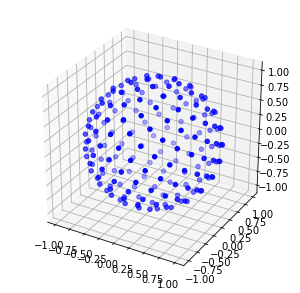

In [122]:
# Plot nodes
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c='b')

In [123]:
# Nearest Neighbors 
tree = cKDTree(np.array(nodes))
stencils = [tree.query(node, stencil_size)[1] for node in nodes]

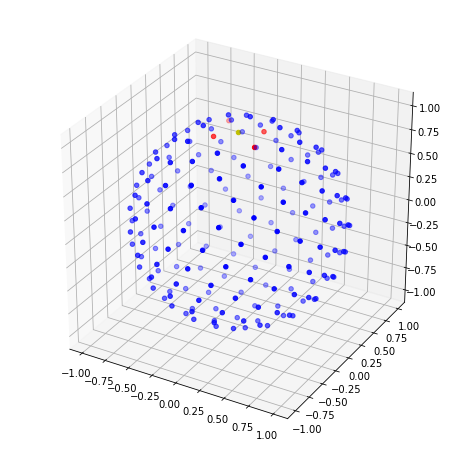

In [125]:
# Plot stencil
center_index = 0
stencil_x = [nodes[i][0] for i in stencils[center_index]]
stencil_y = [nodes[i][1] for i in stencils[center_index]]
stencil_z = [nodes[i][2] for i in stencils[center_index]]

not_stencil_x = [nodes[i][0] for i in range(n) if i not in stencils[center_index]]
not_stencil_y = [nodes[i][1] for i in range(n) if i not in stencils[center_index]]
not_stencil_z = [nodes[i][2] for i in range(n) if i not in stencils[center_index]]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(not_stencil_x, not_stencil_y, not_stencil_z, c='b')
ax.scatter(stencil_x[1:], stencil_y[1:], stencil_z[1:], c='r')
ax.scatter(stencil_x[0], stencil_y[0], stencil_z[0], c='y')

# Approximate Surface Gradient

In [126]:
def dist(node1, node2):
    return np.sqrt( (node1[0]-node2[0])**2 + (node1[1]-node2[1])**2 + (node1[2]-node2[2])**2 )

def P_grad_rbf_x(node1, node2):
    r = dist(node1, node2)
    return d_phi_dr_div_r(r) * (1-r**2) * (node2[0] - node1[0])
def P_grad_rbf_y(node1, node2):
    r = dist(node1, node2)
    return d_phi_dr_div_r(r) * (1-r**2) * (node2[1] - node1[1])
def P_grad_rbf_z(node1, node2):
    r = dist(node1, node2)
    return d_phi_dr_div_r(r) * (1-r**2) * (node2[2] - node1[2])

weights = np.zeros((n, stencil_size))
row_index = [r for r in range(n) for c in range(stencil_size)]
col_index = np.zeros((n, stencil_size))

for i, stencil in enumerate(stencils):
    col_index[i] = stencil
    nn = [nodes[i] for i in stencil]
    
    A = np.array([[rbf(dist(node1, node2)) for node2 in nn] for node1 in nn])
    
    rhs = np.array([[P_grad_rbf_x(node1, node2) for node2 in nn] for node1 in nn])
    weights_grad = la.solve(A, rhs).T
    weights[i] = (weights_grad@weights_grad)[0]
    
    rhs = np.array([[P_grad_rbf_y(node1, node2) for node2 in nn] for node1 in nn])
    weights_grad = la.solve(A, rhs).T
    weights[i] += (weights_grad@weights_grad)[0]
    
    rhs = np.array([[P_grad_rbf_z(node1, node2) for node2 in nn] for node1 in nn])
    weights_grad = la.solve(A, rhs).T
    weights[i] += (weights_grad@weights_grad)[0]
    
C = sp.csc_matrix((weights.ravel(), (row_index, col_index.ravel())),shape=(n,n))

In [127]:
cond(C.todense())

5056.58947382127

# Lagrange Multiplier for extra condition

In [128]:
Clam = sp.vstack( [sp.hstack([C, np.ones((n,1))], format='csr'), 
                    np.block([np.ones((1,n)), np.zeros((1,1))]) ], format='csr')

In [129]:
cond(Clam.todense())

82.10411306792368

# Solve

In [130]:
# l=1
def foo1(node):
    return node[0]*2
def exact1(node):
    return node[0]


# l=3
def foo2(node):
    return (node[0]**2 - node[1]**2) * 6
def exact2(node):
    return (node[0]**2 - node[1]**2)

def foo3(node):
    return (node[0]**2 - node[1]**2) * node[2] * 12
def exact3(node):
    return (node[0]**2 - node[1]**2) * node[2]


foo, exact = foo1, exact1

In [131]:
rhs = [-foo(node) for node in nodes] + [0]
#u = lsqr(Clam, rhs)[0]
u = spsolve(Clam, rhs)
print(u[-1]) # should be near zero
u = u[:-1]

-0.002571813484482835


In [132]:
u_true = np.array([exact(node) for node in nodes])
print(np.max(np.abs(u - u_true)))
print(np.min(u))
print(np.max(u))

0.7510000766546299
-0.24640760397383651
0.24836446186013506


# Plot Solution

Text(0.5,0,'y')

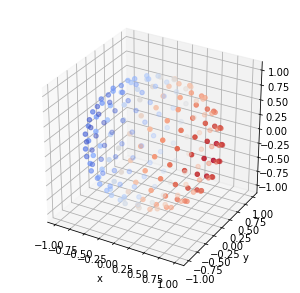

In [133]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c=u, cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('y')

# Actual Solution

Text(0.5,0,'y')

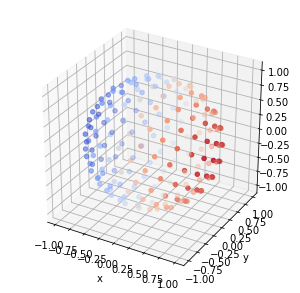

In [134]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c=[exact(node) for node in nodes], cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('y')

In [135]:
120*4

480

In [138]:
for i in range(n):
    print(np.sum(C.todense()[i]))

0.09205377794462066
0.09217759166594419
0.09199889637110914
0.09201914472306072
0.09118460420449992
0.0921198560729124
0.09241181881665739
0.09190190695805711
0.09142632574170761
0.09099685893983178
0.09137904313668344
0.09169014162582556
0.09189327806713266
0.09200321730941141
0.09204024810556177
0.09202267032852163
0.09196570862917497
0.09188172299444375
0.09183990745376036
0.09179718995515174
0.09176870796422065
0.09174135222538382
0.09170932481575278
0.09167031512642154
0.09162371527348512
0.09156974514573335
0.0915090086617738
0.09144226440639613
0.09137030677320013
0.09129390560644879
0.09124241849437453
0.09129524001934897
0.09133977068626109
0.09137648011477495
0.09140588410303963
0.09142852039201443
0.0914449317516528
0.09145565417426837
0.09146120878682495
0.09146209638824132
0.09145879394320389
0.09145175244555048
0.09144139584455502
0.09142812068083117
0.09141229627459779
0.09133056533912054
0.09136988256264544
0.09140734288382646
0.09144286252001166
0.09147640492349751
0.0

In [143]:
print(C[20])

  (0, 7)	43.01939823344114
  (0, 12)	49.97032602184146
  (0, 20)	-228.5440391038292
  (0, 28)	79.89736854218808
  (0, 33)	55.74871501432274
